### Capacitive Discharge (Turner 2013)
This is a benchmark for implementations of Monte Carlo Collisions in Particle-in-Cell codes.

Simulation benchmarks for low-pressure plasmas: Capacitive discharges
M. M. Turner, A. Derzsi, Z. Donkó, D. Eremin, S. J. Kelly et al.
doi: http://dx.doi.org/10.1063/1.4775084

In [1]:
using PyPlot
using PyCall
ov = pyimport("openpmd_viewer")
ts = ov.OpenPMDTimeSeries("/tmp/11_rf_discharge/hdf5")
tμs = 1e6 * ts.t # time in microseconds
dt = ts.t[2] - ts.t[1]
nothing

In [2]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = "Routed Gothic"
rcParams["font.size"] = 15
rcParams["axes.linewidth"] = 1
rcParams["scatter.marker"] = "o"
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"
nothing

In [3]:
_, metadata = ts.get_field("phi")
Lx, Ly = metadata.ymax, metadata.xmax
dx, dy = metadata.dy, metadata.dx
xs, ys = metadata.y, metadata.x
nx, ny = length(xs), length(ys)
e  = ts.get_particle(["id"], "e-")
np = length(e[1])
nothing

In [4]:
pt = ov.ParticleTracker(ts, iteration=512_000, select=Dict("id"=>[0, np]),
    species="e-", preserve_particle_index=false)
it, np = length(ts.iterations), pt.N_selected;
px = zeros(it, np)
py = zeros(it, np)
vx = zeros(it, np)
vy = zeros(it, np)
Ex = zeros(it, ny, nx)
phi = zeros(it, ny, nx)
rho = zeros(it, ny, nx)
nHe = zeros(it, ny, nx)
ne  = zeros(it, ny, nx)
nu1 = zeros(it, ny, nx)
nu2 = zeros(it, ny, nx)
nu3 = zeros(it, ny, nx)
nu4 = zeros(it, ny, nx)
nuA = zeros(it, ny, nx)
nuB = zeros(it, ny, nx)
nothing

In [5]:
using ProgressMeter
@showprogress for i=1:it
    #x, y, ux, uy = ts.get_particle( ["x", "y", "ux", "uy"],
    #    select=pt, iteration=ts.iterations[i], species="e-")
    #px[i, :] = x[:]
    #py[i, :] = y[:]
    #vx[i, :] = ux[:]
    #vy[i, :] = uy[:]
    Ex[i, :, :],= ts.get_field("E", iteration=ts.iterations[i], coord="x")
   phi[i, :, :],= ts.get_field("phi", iteration=ts.iterations[i])
   rho[i, :, :],= ts.get_field("rho", iteration=ts.iterations[i])
   nHe[i, :, :],= ts.get_field("nHe+", iteration=ts.iterations[i])
    ne[i, :, :],= ts.get_field("ne-", iteration=ts.iterations[i])
    nu1[i, :, :, :],= ts.get_field("nuMCC-e--1", iteration=ts.iterations[i])
    nu2[i, :, :, :],= ts.get_field("nuMCC-e--2", iteration=ts.iterations[i])
    nu3[i, :, :, :],= ts.get_field("nuMCC-e--3", iteration=ts.iterations[i])
    nu4[i, :, :, :],= ts.get_field("nuMCC-e--4", iteration=ts.iterations[i])
    nuA[i, :, :, :],= ts.get_field("nuMCC-He+-1", iteration=ts.iterations[i])
    nuB[i, :, :, :],= ts.get_field("nuMCC-He+-2", iteration=ts.iterations[i])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


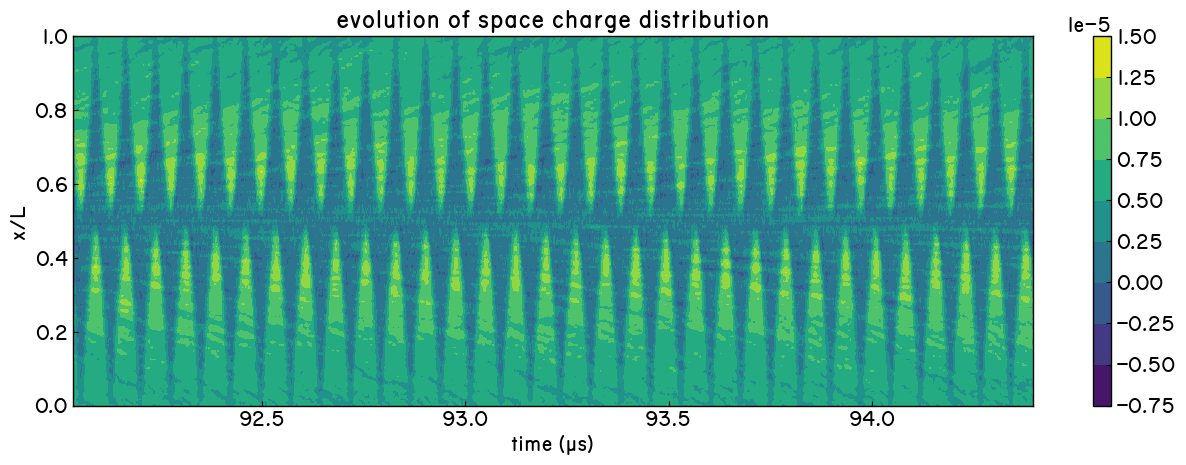

In [31]:
subplot(1,1,1)
contourf(tμs, xs/Lx, rho[:,1,:]')
colorbar()
title("evolution of space charge distribution")
xlabel("time (µs)")
ylabel("x/L")

subplots_adjust(right=2.0)

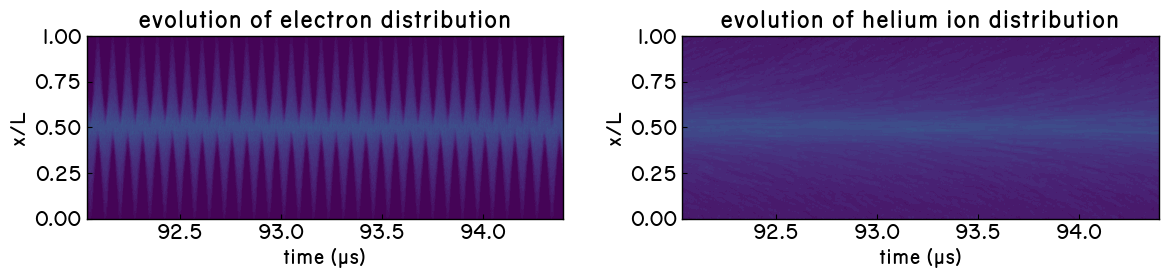

In [32]:
subplot(1,2,1)
contourf(tμs, xs/Lx, ne[:,1,:]', 0.0:1e13:5e14)
title("evolution of electron distribution")
xlabel("time (µs)")
ylabel("x/L")

subplot(1,2,2)
contourf(tμs, xs/Lx, nHe[:,1,:]', 0.0:1e13:5e14)
title("evolution of helium ion distribution")
xlabel("time (µs)")
ylabel("x/L")

subplots_adjust(wspace=0.25, right=1.8, bottom=0.5)

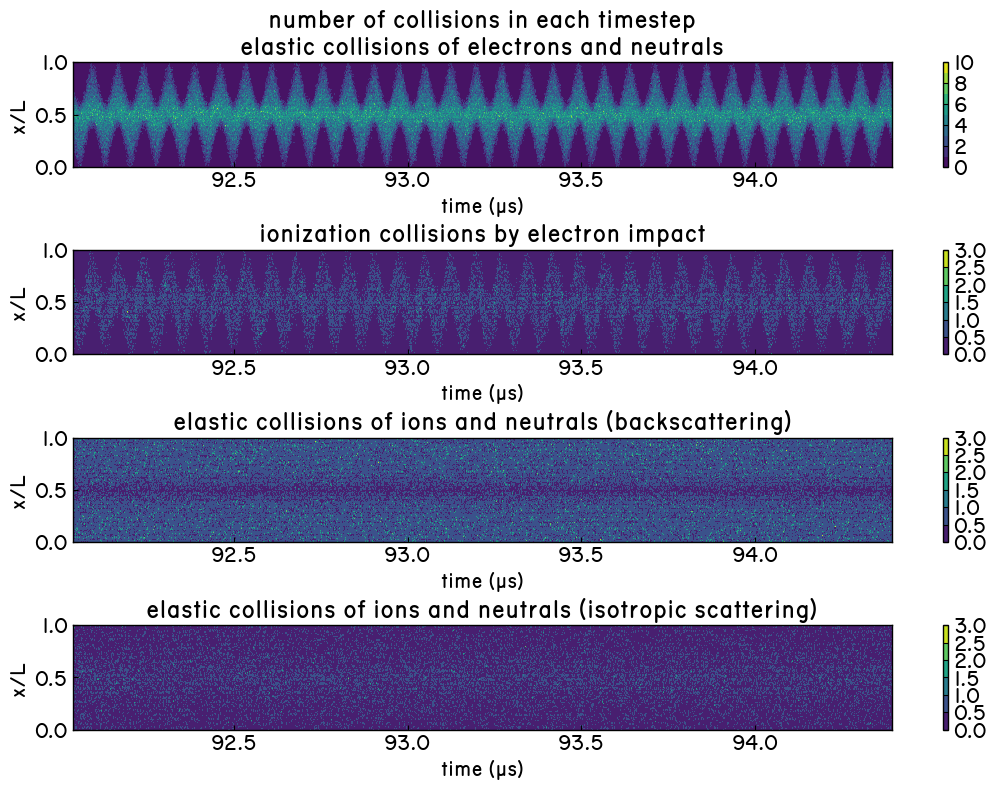

In [33]:
subplot(4,1,1); contourf(tμs, xs/Lx, nu1[:,1,:]', 0:1.0:10.0); colorbar()
title("number of collisions in each timestep\nelastic collisions of electrons and neutrals")
xlabel("time (µs)")
ylabel("x/L")
subplot(4,1,2); contourf(tμs, xs/Lx, nu4[:,1,:]', 0:.5:3.0); colorbar()
title("ionization collisions by electron impact")
xlabel("time (µs)")
ylabel("x/L")
subplot(4,1,3); contourf(tμs, xs/Lx, nuA[:,1,:]', 0:.5:3.0); colorbar()
title("elastic collisions of ions and neutrals (backscattering)")
xlabel("time (µs)")
ylabel("x/L")
subplot(4,1,4); contourf(tμs, xs/Lx, nuB[:,1,:]', 0:.5:3.0); colorbar()
title("elastic collisions of ions and neutrals (isotropic scattering)")
xlabel("time (µs)")
ylabel("x/L")

subplots_adjust(hspace=0.8, left=0.0, right=1.6, top=1.5)

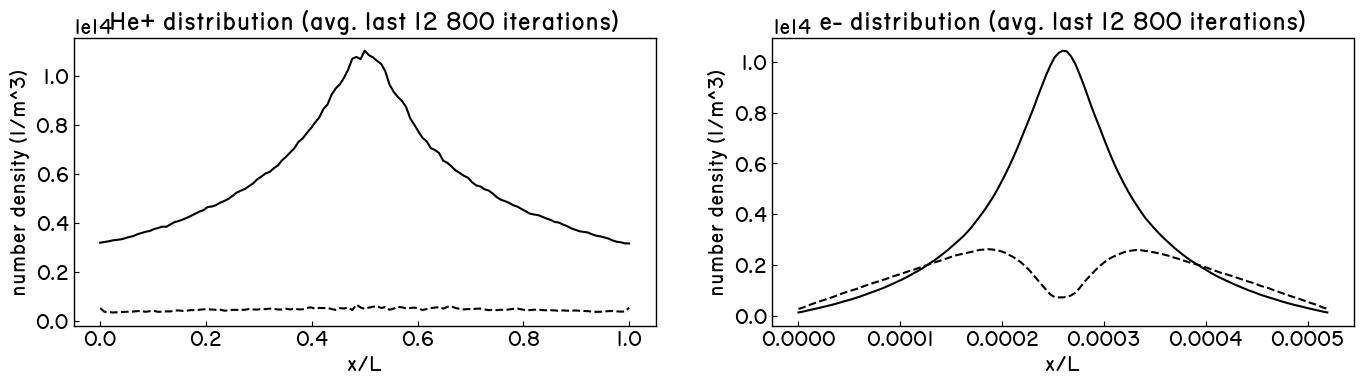

In [34]:
using Statistics

subplot(1,2,1)
title("He+ distribution (avg. last 12 800 iterations)")
plot(xs/Lx, mean(nHe; dims=(1,2))[:], "k-",
     xs/Lx,  std(nHe; dims=(1,2))[:], "k--")
xlabel("x/L")
ylabel("number density (1/m^3)")

subplot(1,2,2)
title("e- distribution (avg. last 12 800 iterations)")
plot(xs/nx, mean(ne; dims=(1,2))[:], "k-",
     xs/nx,  std(ne; dims=(1,2))[:], "k--")
xlabel("x/L")
ylabel("number density (1/m^3)")

subplots_adjust(left=0.0, right=2.0, top=0.6, bottom=0.0)

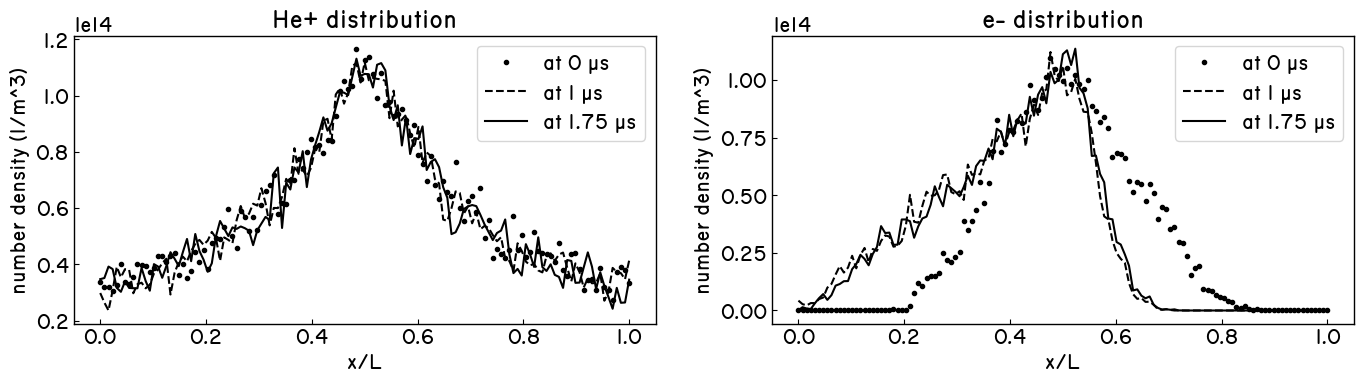

In [35]:
subplot(1,2,1)
title("He+ distribution")
plot(xs/Lx, nHe[1,1,:], "k.",
     xs/Lx, nHe[545,1,:], "k--",
     xs/Lx, nHe[950,1,:], "k-")
legend(["at 0 µs", "at 1 µs", "at 1.75 µs"])
xlabel("x/L")
ylabel("number density (1/m^3)")

subplot(1,2,2)
title("e- distribution")
plot(xs/Lx, ne[1,1,:], "k.",
     xs/Lx, ne[545,1,:], "k--",
     xs/Lx, ne[950,1,:], "k-")
legend(["at 0 µs", "at 1 µs", "at 1.75 µs"])
xlabel("x/L")
ylabel("number density (1/m^3)")

subplots_adjust(left=0.0, right=2.0, top=0.6, bottom=0.0)

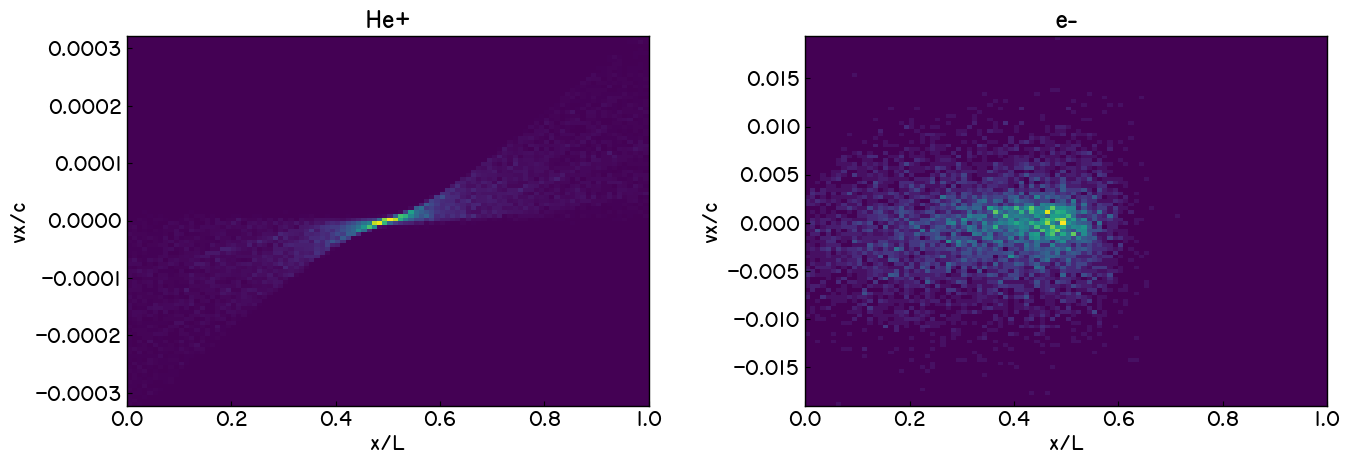

In [55]:
normalized(v) = v/maximum(v)
px, pv = ts.get_particle(var_list=["x","ux"], iteration=ts.iterations[12500], species="He+")
subplot(1,2,1); hist2D(px/Lx, pv, bins=100, range=[(0, 1), extrema(pv)]); xlabel("x/L"); ylabel("vx/c")
title("He+"), xlim(0, 1)

px, pv = ts.get_particle(var_list=["x","ux"], iteration=ts.iterations[12500], species="e-")
subplot(1,2,2); hist2D(px/Lx, pv, bins=100, range=[(0, 1), extrema(pv)]); xlabel("x/L"); ylabel("vx/c")
title("e-"), xlim(0, 1)

subplots_adjust(right=2.0, wspace=0.3)

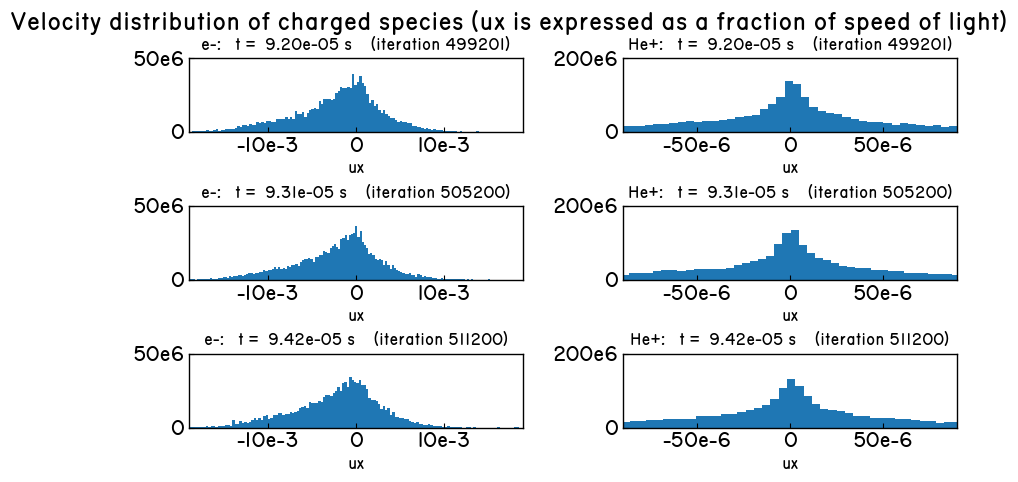

In [61]:
subplot(3,2,1); ts.get_particle( ["ux"], iteration=ts.iterations[1], species="e-", plot=true); ylim(0, 50e6); xlim(-0.019, +0.019);
subplot(3,2,3); ts.get_particle( ["ux"], iteration=ts.iterations[6000], species="e-", plot=true); ylim(0, 50e6); xlim(-0.019, +0.019);
subplot(3,2,5); ts.get_particle( ["ux"], iteration=ts.iterations[12000], species="e-", plot=true); ylim(0, 50e6); xlim(-0.019, +0.019);

subplot(3,2,2); ts.get_particle( ["ux"], iteration=ts.iterations[1], species="He+", plot=true);   ylim(0, 2e8); xlim(-90e-6, +90e-6);
subplot(3,2,4); ts.get_particle( ["ux"], iteration=ts.iterations[6000], species="He+", plot=true); ylim(0, 2e8); xlim(-90e-6, +90e-6);
subplot(3,2,6); ts.get_particle( ["ux"], iteration=ts.iterations[12000], species="He+", plot=true); ylim(0, 2e8); xlim(-90e-6, +90e-6);


suptitle("Velocity distribution of charged species (ux is expressed as a fraction of speed of light)")

subplots_adjust(hspace=1, wspace=.3, left=0.0, right=1.2)#left=0.0, right=1.1, top=2.5, bottom=0.0)

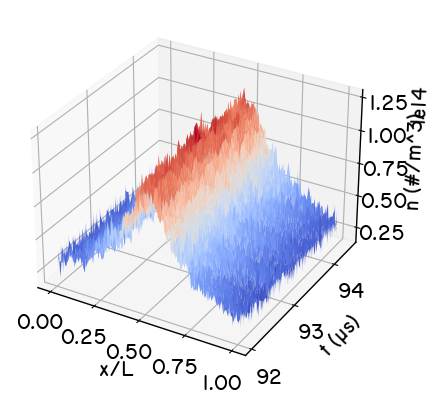

PyObject Text(0.10787434422876385, 0.014452421710066912, 'n (#/m^3)')

In [62]:
plot_surface(xs/Lx, tμs, nHe[:,1,:],
    cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=true)
xlabel("x/L")
ylabel("t (µs)")
zlabel("n (#/m^3)")

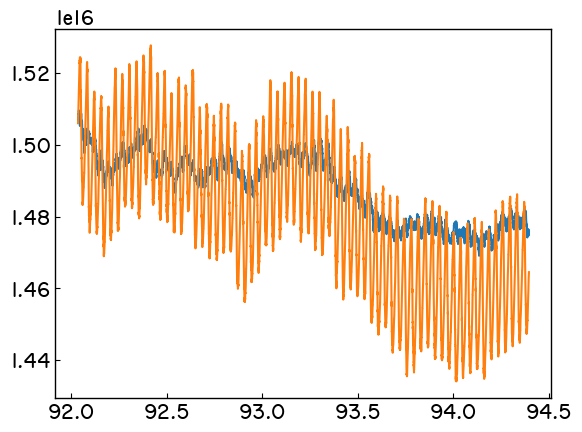

2-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9df377ba60>
 PyObject <matplotlib.lines.Line2D object at 0x7f9df377ba90>

In [80]:
plot(tμs, reshape(sum(nHe; dims=(2,3)), 12_800),
     tμs, reshape(sum(1.795ne; dims=(2,3)), 12_800))

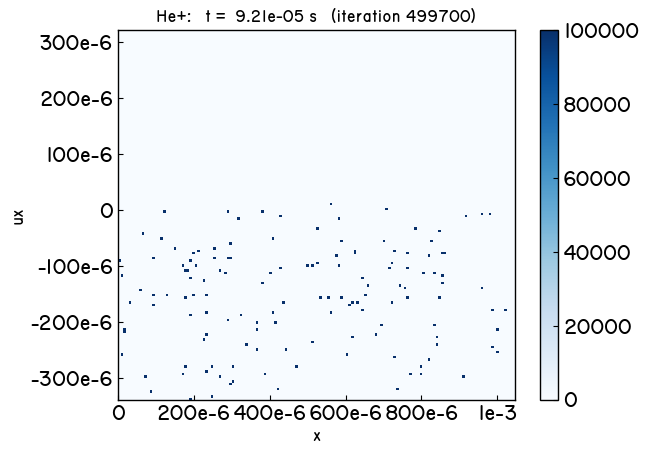

In [25]:
ts.get_particle(var_list=["x", "ux"], iteration=ts.iterations[500], species="He+", plot=true, vmax=1e5);

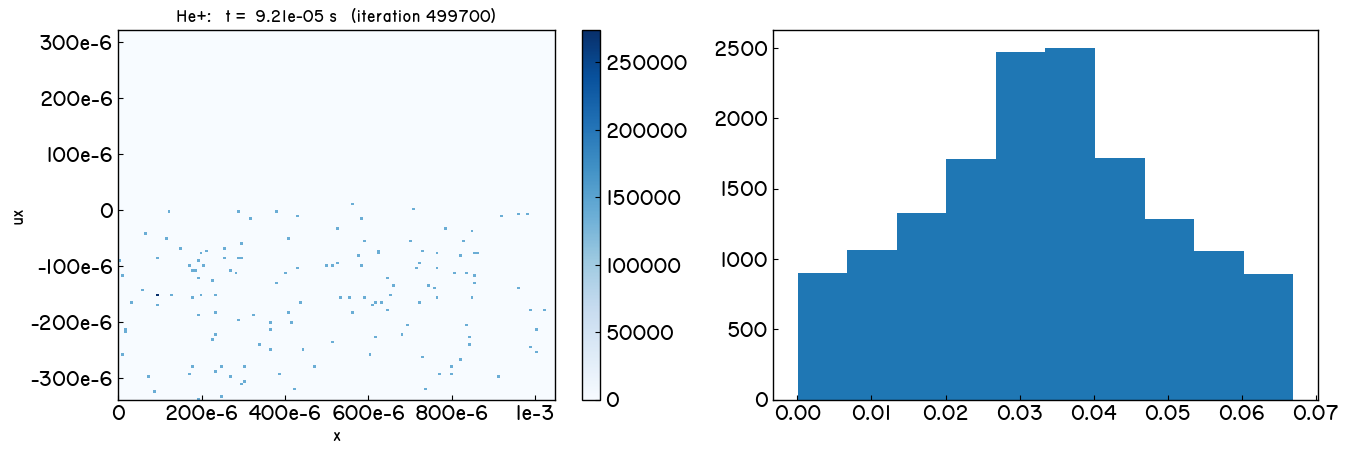

In [26]:
subplot(1,2,1); px13, vx13 = ts.get_particle(var_list=["x","ux"], iteration=ts.iterations[500], species="He+", plot=true)
subplot(1,2,2); hist(px13)
subplots_adjust(right=2.0)